# Week 4 : NLP Disaster Tweets Kaggle Mini-Project

## Brief Description of Problem and Data

Twitter is a social network that has become an important communication channel in times of emergency. Due to its simplicity and practicality, people can announce an emergency in real-time. The purpose of this competition is to build  machine learning model that has the capability to predict which tweets refers to real disasters and which ones does not.

For this project, I will use Natural Language Processing (NLP) ; specifically LSTM to produce the predictions.The data which is comprised of 10,000 hand-classified tweets is taken from Kaggle's website in [HERE](https://www.kaggle.com/competitions/nlp-getting-started/data) and is in form of text or string. 

As this was my first time working with NLP, I used several tutorials and other projects as guidance(see last section for references).

First, I imported all the packages and libraries needed for the project.

In [5]:
import numpy as np 
import pandas as pd 
from sklearn import feature_extraction, linear_model, model_selection, preprocessing, metrics, ensemble
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import plotly
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
import re
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
nltk.download('punkt')
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from gensim.scripts.glove2word2vec import glove2word2vec
import zipfile
import urllib.request

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pietr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pietr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Exploratory Data Analysis (EDA)

After loading the libraries, I proceeded to import the required datasets. The next two lines helped me to understand how does a "disaster tweet" and a "non-disaster tweet" look like through a couple of examples. 

In general, the train dataset consists of 7,613 rows with 5 columns in which I only focused on 2 : "text" (actual tweet message) and "target" (value that helps to identify if its a non disaster of if its a real disaster).

Then, I generated a couple of charts to help me understand the data distribution between these two values (disaster vs non-disaster) and the word count in the tweets to see if there were some texts with a less words than others.

Finally, I went through a process of cleaning to remove content that is not needed for the model. Examples of this content are removing URLs, numbers, stop words and special characters. 

I'll go in more detail before the respective lines of codes.




In [7]:
train_df = pd.read_csv("C:/Users/pietr/OneDrive/Documentos/Masters Degree/Introduction to Deep Learning/MPW4/data/train.csv")
test_df = pd.read_csv("C:/Users/pietr/OneDrive/Documentos/Masters Degree/Introduction to Deep Learning/MPW4/data/test.csv")

In [47]:
train_df[train_df["target"] == 0]["text"].values[3]

'My car is so fast'

In [48]:
train_df[train_df["target"] == 1]["text"].values[7]

"I'm on top of the hill and I can see a fire in the woods..."

In [49]:
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [50]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


The following bar plot tells us that the train dataframe is comprised of ~ 60% of non-disaster tweets and ~ %40 of real disaster tweets. 

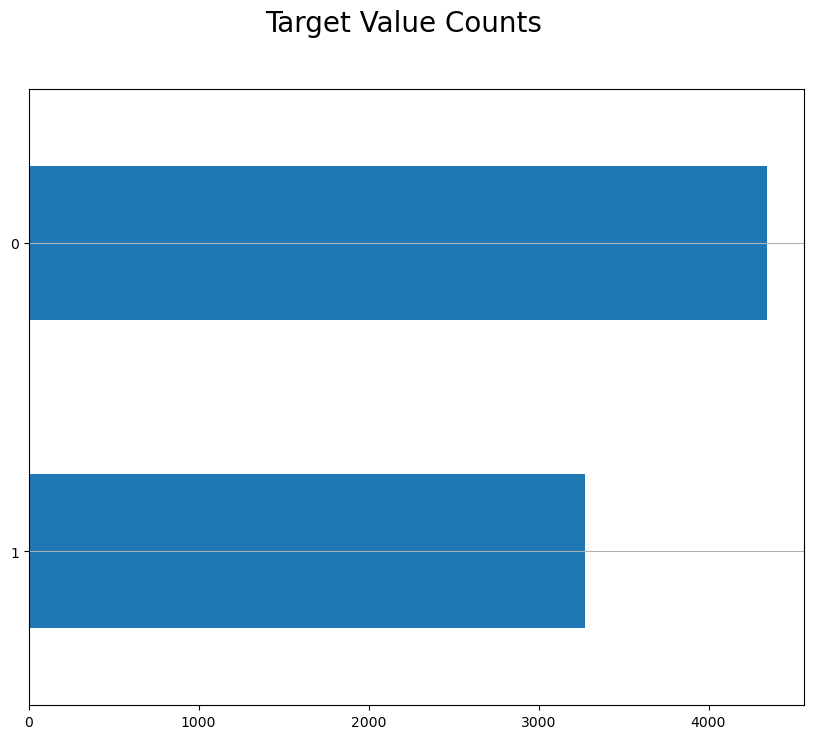

In [32]:
plt.figure(figsize=(10,8))
ax = train_df['target'].value_counts().sort_values().plot(kind="barh")
ax.grid(axis="y")
plt.suptitle("Target Value Counts", fontsize=20)
plt.show()


Next, I generated this histogram to understand the distribution of tweets based on its word count. The majority of tweets are between 11 to 19 words.Considering this, I took the decision of removing tweets with less than 2 words and with more than 25 words in order to optimize training. 

C:\Users\pietr\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



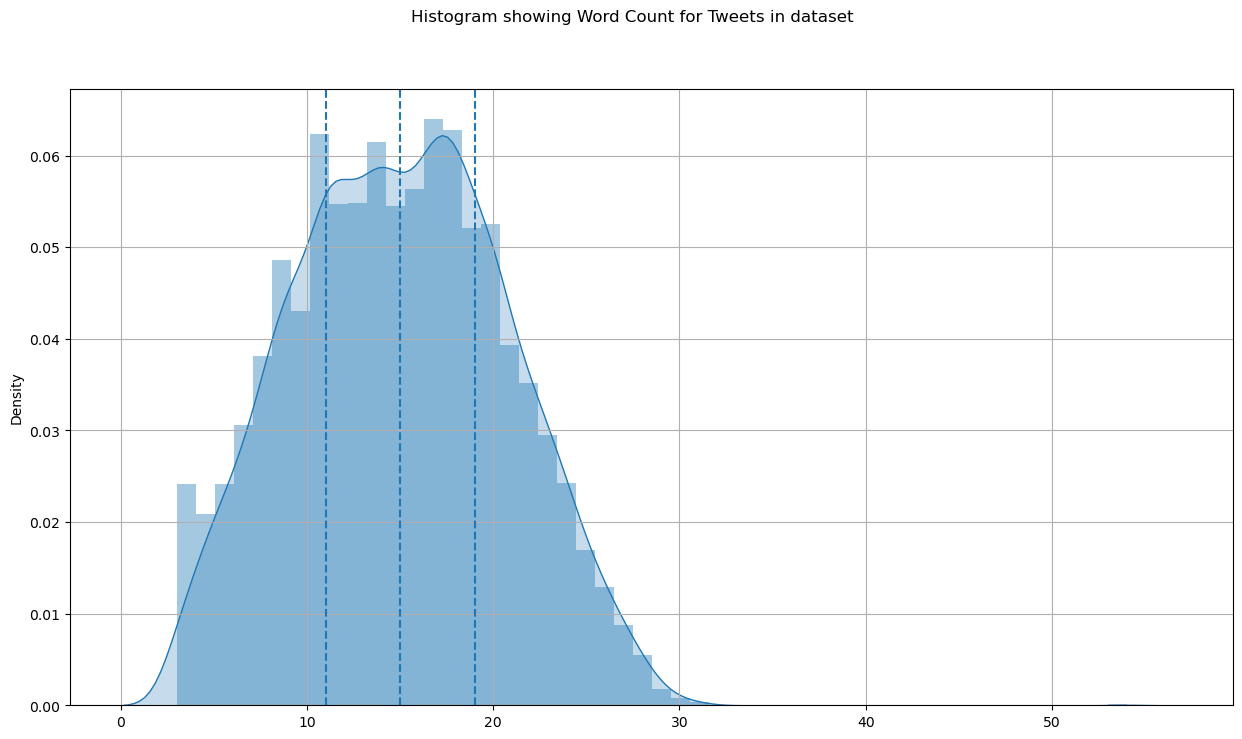

25th percentile:  11.0
mean:  15.0
75th percentile:  19.0


In [40]:
plt.figure(figsize=(15,8))
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split(" ")) )
sns.distplot(train_df['word_count'].values, hist=True, kde=True, kde_kws={"shade": True})
plt.axvline(train_df['word_count'].describe()['25%'], ls="--")
plt.axvline(train_df['word_count'].describe()['50%'], ls="--")
plt.axvline(train_df['word_count'].describe()['75%'], ls="--")

plt.grid()
plt.suptitle("Histogram showing Word Count for Tweets in dataset")
plt.show()


train_df = train_df[train_df['word_count']>2]
train_df = train_df.reset_index()

print("25th percentile: ", train_df['word_count'].describe()['25%'])
print("mean: ", train_df['word_count'].describe()['50%'])
print("75th percentile: ", train_df['word_count'].describe()['75%'])



The final step of the EDA is the cleaning process. In here, I'll remove content from the training dataframe that's not needed like numbers and URLs.  

Through this step, I was able to get familiar with the following concept:
* **Stemming** -> Used to reduce extra characters or letters from a word to its root ("player" / "playing" -> "play")
* **Stop Words** > Words that are commonly used in a language (examples in English : "Than", "that", "is", "are) . The reason why they are used in NLP is to eliminate words that are very common in the respective language that they don't have or carry information that can be useful. 

In the end, I combined columns "keyword" and "text" into one feature to simplify the handling of data

I got both tools from NLKT library.

In [8]:
# Clean text columns
clean_stop_words = set(stopwords.words('english'))
use_stemmer = SnowballStemmer('english')


def clean_text(each_text):

    # remove URL from text
    no_url_text = re.sub(r"http\S+", "", each_text)
    
    # remove numbers from text
    no_num_text = re.sub(r'\d+', '', no_url_text)

    # tokenize each text
    text_tokens = word_tokenize(no_num_text)
    
    # remove spatial character
    clean_text = []
    for word in text_tokens:
        clean_text.append("".join([b for b in word if b.isalnum()]))

    # remove stop words and lower
    no_stop_word_text = [c.lower() for c in clean_text if not c in clean_stop_words]  

    # do stemming
    stem_text = [use_stemmer.stem(c) for c in no_stop_word_text]
    
    return " ".join(" ".join(stem_text).split())


train_df['clean_text'] = train_df['text'].apply(lambda x: clean_text(x) )
train_df['keyword'] = train_df['keyword'].fillna("none")
train_df['clean_keyword'] = train_df['keyword'].apply(lambda x: clean_text(x))

# Combine column 'clean_keyword' and 'clean_text' into one
train_df['keyword_text'] = train_df['clean_keyword'] + " " + train_df["clean_text"]


## Model's Architecture
For this project I chose to use LSTM (Long Short Term Memory network) to train my RNN model as it is the one we reviewed throug the course. This type of model is able to remember data for a long period of time as it has an internal memory system.

As I did in the previous project, the first step was to split the train dataframe into two ( "train" and "test" ) through the Sklearn's "train_test_split" function. 

In [9]:
feature = 'keyword_text'
label = "target"

# split train and test
X_train, X_test,y_train, y_test = model_selection.train_test_split(train_df[feature],
                                                                   train_df[label],
                                                                   test_size=0.3,
                                                                   random_state=0, 
                                                                   shuffle=True)

In addition, I decided to use GloVe to process texts to matrix or vectors. The following two set of codes helped me to import the glove dataset required for the model's hyperparameter. 

In [113]:
path = 'C:/Users/pietr/OneDrive/Documentos/Masters Degree/Introduction to Deep Learning/MPW4'
res_path = path+'results/'
 
urllib.request.urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", path + 'glove.6B.zip')

('C:/Users/pietr/OneDrive/Documentos/Masters Degree/Introduction to Deep Learning/MPW4glove.6B.zip',
 <http.client.HTTPMessage at 0x2c35f15d850>)

In [114]:
with zipfile.ZipFile(path + "glove.6B.zip","r") as zip_ref:
    zip_ref.extractall(path)

First, I defined the hyperparameters used for the model. As I learned in the previous project, if I want to improve the performance of my model, I would come back to this section and play around with these values.

Next, I created train and test labels to understand the shape of the data. This is an important step because neural networks need inputs with same shape and size. 

In [10]:
# Define hyperparameters
path_to_glove_file = 'C:/Users/pietr/OneDrive/Documentos/Masters Degree/Introduction to Deep Learning/MPW4/glove.6B.300d.txt' # download link: http://nlp.stanford.edu/data/glove.6B.zip
embed_dim = 300
learning_rate = 1e-3
batch_size = 1024
epochs = 20
sequence_len = 100

In [11]:
# Define train and test labels
y_train_LSTM = y_train.values.reshape(-1,1)
y_test_LSTM = y_test.values.reshape(-1,1)

print("Training Y :", y_train_LSTM.shape)
print("Testing Y :", y_test_LSTM.shape)

Training Y : (5329, 1)
Testing Y : (2284, 1)


Another new concept that I learned in this project is "Tokenization". Tokenization is the process of breaking phrases into a series of words or characters called "tokens". This is an intermediate step in the process of vectorization (which is the technique of mapping words to vector of numbers).

I performed the "tokenization" by using the Keras library.

In [12]:
# Tokenize train data
token= Tokenizer()
token.fit_on_texts(X_train)

word_index = token.word_index
vocab_size = len(word_index) + 1
print("Vocabulary Size: ", vocab_size)

Vocabulary Size:  11271


After performing the tokenization, I proceeded to do a "padding" step in order to ensure that we have the same size and shape of inputs. This is useful as we know that every tweet has different number of words. Padding allows us to establish a max number for each tweet and drop or fill words in order to get the same number through the process. 

In [13]:
# Pad train and test 
X_train = pad_sequences(token.texts_to_sequences(X_train), maxlen=sequence_len)
X_test = pad_sequences(token.texts_to_sequences(X_test), maxlen=sequence_len)

print("Training X : ", X_train.shape)
print("Testing X : ", X_test.shape)

Training X :  (5329, 100)
Testing X :  (2284, 100)


The following steps are related with Word Embedding, which is a process where words that have the same meaning have a similar representation; this is done by mapping each word to a vector.

Once word embeddings are read through GloVe, the next step is to create the layers through Keras.

In [14]:
# Read word embeddings
embed_index = {}
f=open(path_to_glove_file,encoding="utf8")
for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embed_index[word] = coefs

print("Found %s word vectors." % len(embed_index))

Found 400000 word vectors.


In [15]:
# Define embedding layer in Keras
embed_matrix = np.zeros((vocab_size, embed_dim))
for word, i in word_index.items():
    embed_vector = embed_index.get(word)
    if embed_vector is not None:
        embed_matrix[i] = embed_vector
        
embed_layer = tf.keras.layers.Embedding(vocab_size,
                                            embed_dim,
                                            weights=[embed_matrix],
                                            input_length=sequence_len,
                                            trainable=False)

Once the word embedding process finishes, the next step is to define the model's architecture. For this project, I chose to start with the embedded layer created in the previous step in order to generate an embedding vector for each sequence. Then, I applied what I learned from my previous project by using a convolutional model as this is again, another binary classification problem ( real disaster = "1" , non-disaster = "0"). In addition, I also applied the same optimization model: Adam optimization with binary_crossentropy as a loss function. 

In [17]:
# Define model architecture
seq_input = Input(shape=(sequence_len, ), dtype='int32')
embed_sequences = embed_layer(seq_input)

x = Conv1D(128, 5, activation='relu')(embed_sequences)
x = Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
RNN_model = Model(seq_input, outputs)
RNN_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          3381300   
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           192128    
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                           

In [20]:
# Optimize the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

Finally, we get to the training step. As it happened to me before, I had to lower down the epochs to 10 due to the processing capabilities of my computer. In general, I believe I got a very good performance of 0.965 accuracy and a 0.090of loss.

In [21]:
# LSTM model Training Process
RNN_model = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10
167/167 [==============================] - 147s 811ms/step - loss: 0.5322 - accuracy: 0.7433 - val_loss: 0.4860 - val_accuracy: 0.7815
Epoch 2/10
167/167 [==============================] - 137s 820ms/step - loss: 0.4576 - accuracy: 0.7926 - val_loss: 0.4782 - val_accuracy: 0.7903
Epoch 3/10
167/167 [==============================] - 136s 817ms/step - loss: 0.3839 - accuracy: 0.8289 - val_loss: 0.5716 - val_accuracy: 0.7780
Epoch 4/10
167/167 [==============================] - 137s 822ms/step - loss: 0.3199 - accuracy: 0.8660 - val_loss: 0.5114 - val_accuracy: 0.7736
Epoch 5/10
167/167 [==============================] - 136s 815ms/step - loss: 0.2383 - accuracy: 0.9049 - val_loss: 0.6803 - val_accuracy: 0.7697
Epoch 6/10
167/167 [==============================] - 136s 817ms/step - loss: 0.1890 - accuracy: 0.9278 - val_loss: 0.6795 - val_accuracy: 0.7675
Epoch 7/10
167/167 [==============================] - 138s 825ms/step - loss: 0.1449 - accuracy: 0.9430 - val_loss: 0.8003 -

The following plot helped me to understand better the model's performance by plotting Accuracy versus Training losses. We can see that the model's accuracy increases while loss decreases through the epochs as expected.

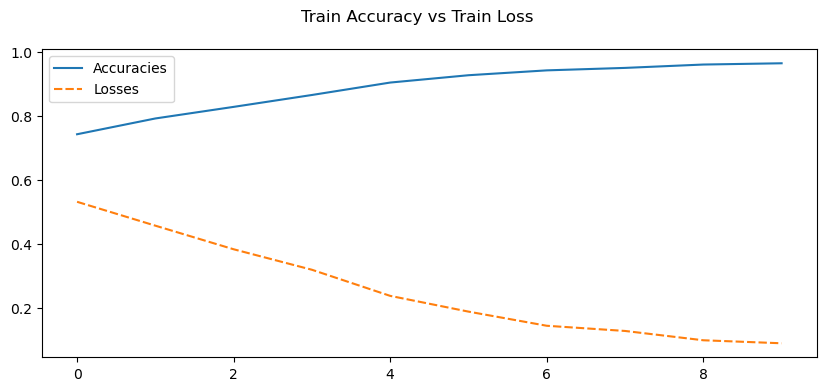

In [23]:
# Plotting train accuracy and loss
accur= RNN_model.history['accuracy']
losses = RNN_model.history['loss']
accur_losses = list(zip(accur,losses))

accur_losses_df = pd.DataFrame(accur_losses, columns={"Losses", "Accuracies"})

plt.figure(figsize=(10,4))
plt.suptitle("Train Accuracy vs Train Loss")
sns.lineplot(data=accur_losses_df)
plt.show()

## Results and Analysis

After the training, I'll evaluate the model's performance and accuracy. For this step, I'll get the F-score and generate a confusion matirix, which besides helping me to perform the analysis, it also helped me to grasp better the concepts.

F-score is the harmonic mean of recall and precision. Recall relates to how many of the total number of data that were correctly labeled as positive, were actually positive  whereas Precision relates to how many of the total number of data that were correctly labeled as positive, were labeled positive correctly.

In regards of the confusion matrix, it is a table that shows the model's performance in comparison to two classes, which in this case would be"0"s and "1"s. 

The report shown below is based on calculations of true and false positives and true and false negatives. I got an F-score of 0.81 for "0" and 0.70 for  "1" with an accuracy of 0.76.

In general, my model had a better performance detecting non-disaster tweets ("0") than real disaster tweets ("1").

In [24]:
# Evaluate the model
predicted = model.predict(X_test, verbose=1, batch_size=10000)

y_predicted = [1 if each > 0.5 else 0 for each in predicted]

score, test_accuracy = model.evaluate(X_test, y_test, batch_size=10000)

print("Test Accuracy: ", test_accuracy)
print(metrics.classification_report(list(y_test), y_predicted))

1/1 [==============================] - 3s 3s/step - loss: 1.0218 - accuracy: 0.7644
Test Accuracy:  0.764448344707489
              precision    recall  f1-score   support

           0       0.78      0.83      0.81      1338
           1       0.74      0.67      0.70       946

    accuracy                           0.76      2284
   macro avg       0.76      0.75      0.75      2284
weighted avg       0.76      0.76      0.76      2284



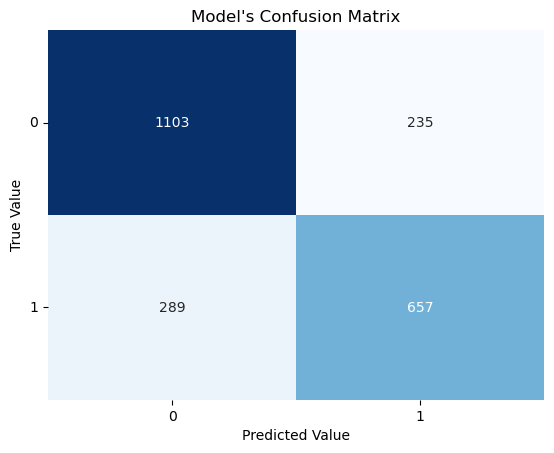

In [319]:
# Plot confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_predicted)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Blues', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Model's Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)
plt.show()

## Preparation for Data Submission

This final step has to do with preparing the data for submission to Kaggle's website. The competition requires to have the results in a csv file with 3,263 rows and a header.

First, I uploaded the sample dataset to apply my model to. I did some padding and confirmed that the dataset had indeed the 3,263 reqiured values. Then, I used my model on this dataset to perform the predictions.

Finally, I added I column to the sample dataset containing my model's results and exported it to a .csv file.

In [320]:
sample_submission = pd.read_csv("C:/Users/pietr/OneDrive/Documentos/Masters Degree/Introduction to Deep Learning/MPW4/data/sample_submission.csv")

In [326]:
X_val= test_df['text']
X_val = pad_sequences(token.texts_to_sequences(X_val), maxlen=sequence_len)
print(X_val.shape)

(3263, 100)


In [329]:
y_pred2 = model.predict(X_val,verbose=1, batch_size=10000)
y_pred_adj = [1 if x >= 0.5 else 0 for x in y_pred2]
print(y_pred_adj)

1/1 [==============================] - 4s 4s/step
[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0

In [330]:
sample_submission['target'] = np.round(y_pred_adj).astype('int')
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1


In [331]:
sample_submission.to_csv("submission_test1.csv", index=False)

## Conclusion

In conclusion, I enjoyed this project as I was able to use the knowledge I previously acquired plus the opportunity to learn new concepts and toolkits. This work is a result of all the resources I found and I was able to combine and put together as needed.

I believe the accuracy and loss values delivered by my model are pretty good but I'm also aware that can be improven by updating input data, apply other training techniques or playing with the model's hyperparameters.

As next steps, I would like to use at least three out of all the techniques I was able to find while I was investigating and figuring out how to do this task.

## References

* Kaggle. NLP Getting Started Tutorial. https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial/notebook
* Towards Data Science. Detecting Disaster from Tweets (Classical ML and LSTM Approach). https://towardsdatascience.com/detecting-disaster-from-tweets-classical-ml-and-lstm-approach-4566871af5f7
* Opinosis Analytics. What are Stop Words? https://www.opinosis-analytics.com/knowledge-base/stop-words-explained/#:~:text=Stop%20words%20are%20a%20set,carry%20very%20little%20useful%20information.
* Github. Machine Learning approach to predict real or fake tweets about disaster. https://github.com/raklugrin01/Disaster-Tweets-Analysis-and-Classification/blob/main/disaster-tweets-classification-using-ml.ipynb
* Kaggle. NLP with Disaster Tweets using LSTM. https://www.kaggle.com/code/sandhyakrishnan02/nlp-with-disaster-tweets-using-lstm/notebook
* TensorFlow. API Docs. https://www.tensorflow.org/api_docs/python/tf/keras/

